# **Домашнее задание №4**
1. Возьмите любой временной ряд, который вам по душе. Задайте модель этого ряда, запишите ее в форме LSS. Прогоните модель через фильтр Калмана, проведите сглаживание.

2. Вспомним школьную программу. Кто-то зачем-то выстрелил из пушки по воробьям. В воробьев не попал, но зато старательно измерил координаты (𝑥𝑖,𝑦𝑖) летящего ядра (см. прикрепленный файл). Ядро было выпущено с начальной скоростью 𝑣0 под углом 𝛼 к горизонту.
Запишите данную задачу в форме LSS если известно, что координаты измерены с ошибкой, имеющей нормальное распределение с нулевым математическим ожиданием и некоторой дисперсией 𝜎2.

3. Со звездочкой. Подберите начальные значения 𝑣0,𝛼,𝜎, обеспечивающие наилучшее приближение данных сглаженным процессом.
Решать задачу надо при помощи фильтра Калмана,
Если не получается получить обратную матрицу, то попробуйте взять псевдо-обратную.
Все решения должны быть с подробными комментариями!

# **Предисловие**

***«Студенты — это сила, ум и, конечно, лень. Более ленивых людей в мире больше нет»*** (c) неизвестный автор 

# **Библиотеки**

In [49]:
# доустановка необходимых библиотек (пока пишу, еще не знаю, но по этикету должно быть) 
# pip install numpy pandas matplotlib scipy

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import json

# **Задание 1**

Возьмите любой временной ряд, который вам по душе. Задайте модель этого ряда, запишите ее в форме LSS. 

Прогоните модель через фильтр Калмана, проведите сглаживание.

Filtered (первые 5): [10.          9.74886878  9.50497035  9.21317235  9.00137278]
Smoothed (первые 5): [9.22321177 9.13776506 9.01609486 8.88603415 8.78457685]
Filtered (последние 5): [2.65207433 2.58397489 2.53427293 2.49799826 2.4445078 ]
Smoothed (последние 5): [2.54661778 2.50758238 2.47930522 2.45895858 2.4445078 ]


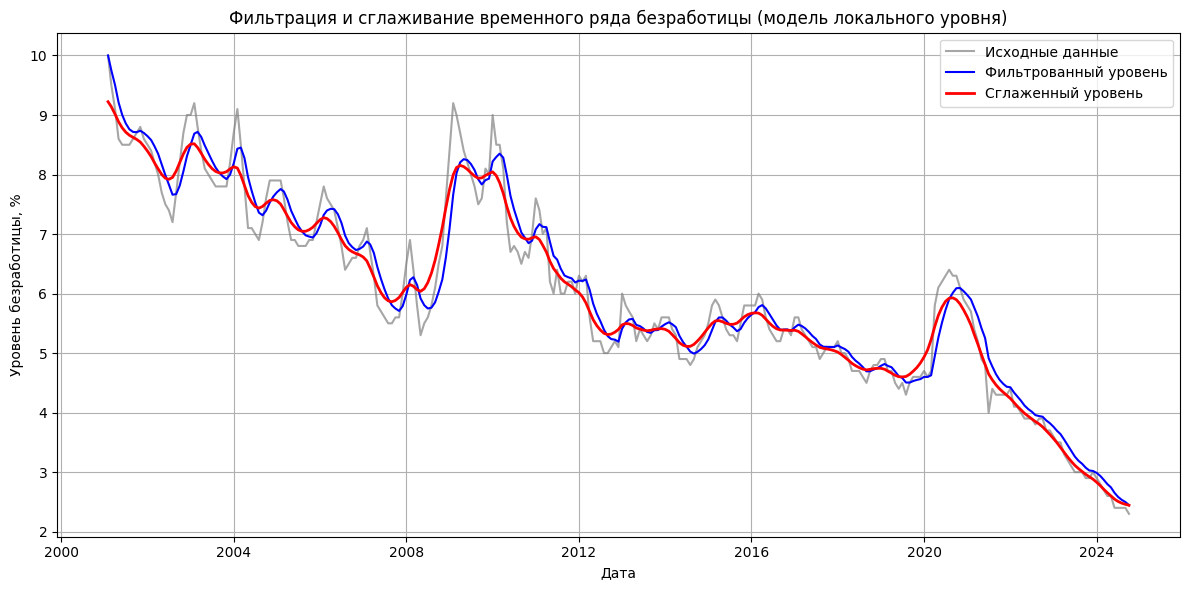

In [51]:
# Чтение данных - это база 
data = pd.read_csv('GDP_RUSSIA.csv', parse_dates=['Date'])
y_obs = data['UNEMP'].values  # наблюдаемый временной ряд
T = len(y_obs) # кол-во наблюдений 

# LSS-модель 
A = np.array([[1.0]])  # М-ца перехода состояния        
G = np.array([[1.0]])  # М-ца наблюдения      
Q = 0.01  # VAR шума процесса                  
R = 0.1  # VAR шума измерения     

# М-цы шумов              
C = np.array([[np.sqrt(Q)]])    
H = np.array([[np.sqrt(R)]])   

# Начальное состояние
x0 = np.array([[y_obs[0]]])    # первое наблюдение - начальное состояние
P0 = np.array([[1.0]])         # начальная неопределённость, а в народе ковариация 


# Фильтер Калмана 
def kalman_filter(y, A, G, C, H):
    n = y.shape[0]
    x_filtered = np.zeros((n, 1))
    P_filtered = np.zeros((n, 1, 1))
    x_pred = x0.copy()
    P_pred = P0.copy()
    
    for t in range(n):
        S = G @ P_pred @ G.T + H @ H.T  # ковариация инновации
        K = P_pred @ G.T @ np.linalg.inv(S) # коэффициент Калмана
        x_filt = x_pred + K @ (y[t] - G @ x_pred) # скорректированное состояние те обновленное состояние прогноз + коррекция
        P_filt = (np.eye(1) - K @ G) @ P_pred # ковариация после коррекции
        x_filtered[t] = x_filt
        P_filtered[t] = P_filt
        
        # Прогноз для следующего шага 
        x_pred = A @ x_filt
        P_pred = A @ P_filt @ A.T + C @ C.T
    
    return x_filtered.squeeze(), P_filtered.squeeze()


# Сглаживание RTS 
def rts_smoother(x_filt, P_filt, A, C):
    n = len(x_filt)
    x_smooth = np.zeros_like(x_filt)
    P_smooth = np.zeros_like(P_filt)
    
    # Начальное условие: последнее сглаженное состояние = последнее отфильтрованное
    x_smooth[-1] = x_filt[-1]
    P_smooth[-1] = P_filt[-1]
    
    # Обратный проход
    for t in range(n - 2, -1, -1):
        P_pred_next = A * P_filt[t] * A + C[0, 0]**2
        J = P_filt[t] * A / P_pred_next  # Коэффициент сглаживания + дальше обновление 
        x_smooth[t] = x_filt[t] + J * (x_smooth[t + 1] - A * x_filt[t])
        P_smooth[t] = P_filt[t] + J**2 * (P_smooth[t + 1] - P_pred_next)
    return x_smooth


# Запуск всего этого безобразия или официальным языком запуск фильтрации и сглаживания
x_filt, P_filt = kalman_filter(y_obs, A, G, C, H)
x_smooth = rts_smoother(x_filt, P_filt, A[0, 0], C)

print("Filtered (первые 5):", x_filt[:5])
print("Smoothed (первые 5):", x_smooth[:5])
print("Filtered (последние 5):", x_filt[-5:])
print("Smoothed (последние 5):", x_smooth[-5:])

# еще бы чуть-чуть и получился бы флаг России :) 
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], y_obs, label='Исходные данные', color='gray', alpha=0.7)
plt.plot(data['Date'], x_filt, label='Фильтрованный уровень', color='blue')
plt.plot(data['Date'], x_smooth, label='Сглаженный уровень', color='red', linewidth=2)
plt.legend()
plt.title('Фильтрация и сглаживание временного ряда безработицы (модель локального уровня)')
plt.xlabel('Дата')
plt.ylabel('Уровень безработицы, %')
plt.grid(True)
plt.tight_layout()
plt.show()

# **Задание 2**

Вспомним школьную программу. Кто-то зачем-то выстрелил из пушки по воробьям. 

В воробьев не попал, но зато старательно измерил координаты (𝑥𝑖,𝑦𝑖) летящего ядра (см. прикрепленный файл). 

Ядро было выпущено с начальной скоростью 𝑣0 под углом 𝛼 к горизонту.

Запишите данную задачу в форме LSS если известно, что координаты измерены с ошибкой, имеющей нормальное распределение с нулевым математическим ожиданием и некоторой дисперсией 𝜎2.

Матрица перехода A:
 [[ 1.     0.     1.     0.     0.   ]
 [ 0.     1.     0.     1.    -4.905]
 [ 0.     0.     1.     0.     0.   ]
 [ 0.     0.     0.     1.    -9.81 ]
 [ 0.     0.     0.     0.     1.   ]]

Матрица наблюдения G:
 [[1 0 0 0 0]
 [0 1 0 0 0]]

Шум измерения R:
 [[1. 0.]
 [0. 1.]]

Начальное состояние s0: [ 0.          0.         35.35533906 35.35533906  1.        ]


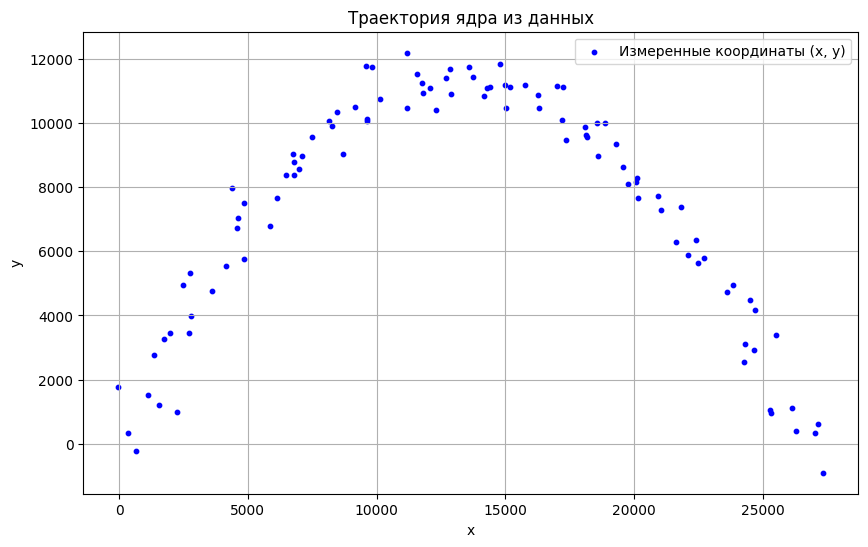

In [52]:
with open('ДЗ3.json', 'r') as f:
    data = json.load(f)
x = np.array(data[0])  # Координаты x
y = np.array(data[1])  # Координаты y
z = np.column_stack((x, y))  # Наблюдения z_t = [x_i, y_i]^T

# Параметры
dt = 1.0  # Шаг времени
g = 9.81  # Ускорение свободного падения
sigma = 1.0  # Стандартное отклонение шума измерения

# Матрица перехода A
A = np.array([
    [1, 0, dt, 0, 0],
    [0, 1, 0, dt, -0.5 * g * dt**2],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, -g * dt],
    [0, 0, 0, 0, 1]
])

# Матрица наблюдения G
G = np.array([
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0]
])

# Шум состояния (детерминированная траектория)
C = np.zeros((5, 1))

# Шум измерения
R = sigma**2 * np.eye(2)


v0 = 50.0
alpha = np.pi / 4
s0 = np.array([
    0.0,  # x0
    0.0,  # y0
    v0 * np.cos(alpha),  # vx0
    v0 * np.sin(alpha),  # vy0
    1.0  # константа для LSS
])

# Вывод параметров
print("Матрица перехода A:\n", A)
print("\nМатрица наблюдения G:\n", G)
print("\nШум измерения R:\n", R)
print("\nНачальное состояние s0:", s0)


plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Измеренные координаты (x, y)', color='blue', s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Траектория ядра из данных')
plt.legend()
plt.grid(True)
plt.show()

### **Дорогой Дедушка Мороз, подари мне внимательность..., чтобы я потом все не переделывал**

# **Задание 3***

Со звездочкой. Подберите начальные значения 𝑣0,𝛼,𝜎, обеспечивающие наилучшее приближение данных сглаженным процессом.

Решать задачу надо при помощи фильтра Калмана,

Если не получается получить обратную матрицу, то попробуйте взять псевдо-обратную.

Все решения должны быть с подробными комментариями!

# **Назовем это красней нитью повествования**

Главный вопрос, который мы должны поставить - "А что мы собственно хотим?"

Найти параметры траектории ядра, а именно v0 a σ, которые наилучшим образом объясняют зашумленные наблюдения те х y

Для этого колдовства мы будем использовать максимизацию правдоподобия 

Вычислим правдоподобие через Калмана 

После оценки параметров --> получим сглаженную траекторию 


####################################################################################################################################

***Варкалось. Хливкие шорьки***

***Пырялись по наве,***

***И хрюкотали зелюки,***

***Как мюмзики в мове***

***(C) Л.Кэрролл***

Именно с этими словами в голове, все было написано ниже, надеюсь, все получится, в крайнем случае нет, но я хотя бы попробовал :)

Оценки:
 v0 = 533.355
 alpha = 59.65°
 sigma = 496.139


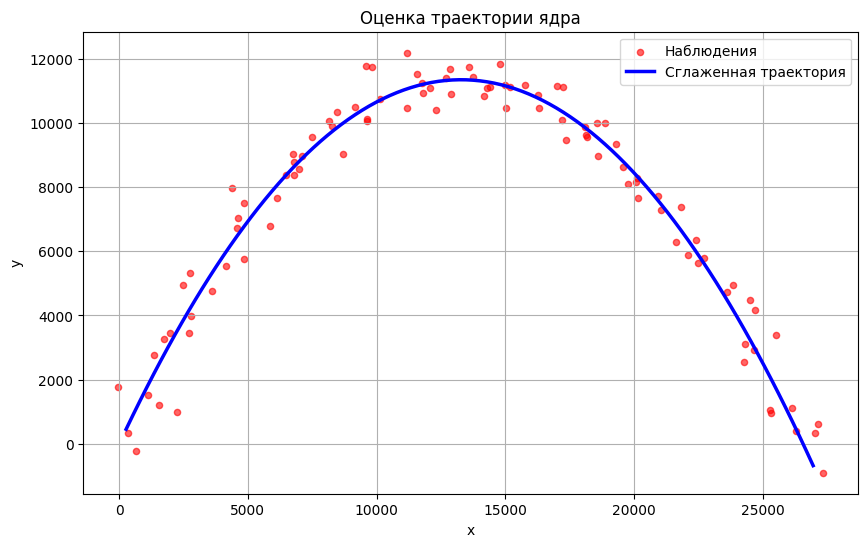

In [53]:
# вычисляет отрицательный логарифм правдоподобия для минимизации наблюдений, где dt и g - физ константы, q_eps, reg_S - регуляционные параметры для устойчивости  
def kalman_loglik(params, z, dt, g, q_eps=1e-8, reg_S=1e-8):
    v0, alpha, log_sigma = params
    sigma = np.exp(log_sigma)
    if not (v0 > 0 and 0.0 < alpha < np.pi/2): # # накинем ограничения параметров скорость положительна, а угол лежит между 0 и 90 
        return 1e10
    T = z.shape[0]
    
# Построение LSS - модели 
    A = np.array([  # Матрица А моделирует динамику (или матрицу переходов состояния)
        [1., 0., dt, 0., 0.],
        [0., 1., 0., dt, -0.5 * g * dt**2],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., -g * dt],
        [0., 0., 0., 0., 1.]
    ])
    G = np.array([[1., 0., 0., 0., 0.], 
                  [0., 1., 0., 0., 0.]]) # здесь только x y наблюдаются 
    Q = np.zeros((5,5))  
    Q += q_eps * np.eye(5)  # добавим шууууум (малый)
    R = (sigma**2) * np.eye(2)  # ковариация шума измерений 
    s0 = np.array([0., 0., v0 * np.cos(alpha), v0 * np.sin(alpha), 1.])  # начальные координаты
    P0 = np.eye(5) # начальная неопределенность
    s_pred = s0.copy() 
    P_pred = P0.copy()
    loglik = 0.0
    m = 2 # размер наблюдения
    for i in range(T):
        s_pred = A @ s_pred
        P_pred = A @ P_pred @ A.T + Q
        y_pred = G @ s_pred
        innov = (z[i] - y_pred).reshape(m)
        S = G @ P_pred @ G.T + R # ковариация инноваций 
        S += reg_S * np.eye(m) # регуляризация для предотвращения сингулярности
        
        # Обработка сингулярности
        try:
            S_inv_innov = np.linalg.solve(S, innov)
            K = (P_pred @ G.T) @ np.linalg.inv(S)
        except np.linalg.LinAlgError:  # в исключительном случае используем псевдо-обратную
            S_inv = np.linalg.pinv(S)
            S_inv_innov = S_inv @ innov
            K = (P_pred @ G.T) @ S_inv
            
        # Вычисление лог-детерминанта
        sign, logdet = np.linalg.slogdet(S)
        if sign <= 0:
            return 1e10  # эт если все оооооооочень плохо 
        
          # Обновление лог-правдоподобия 
        loglik += -0.5 * (logdet + innov.dot(S_inv_innov) + m * np.log(2*np.pi))
        
        # Коррекция состояния
        s_upd = s_pred + K @ innov
        P_upd = (np.eye(5) - K @ G) @ P_pred
        s_pred = s_upd
        P_pred = P_upd
    return -float(loglik)

# Запускает фильтр Калмана + RTS-сглаживание с фиксированными параметрами и возвращает сглаженные координаты

# Тут много что дублируется, я думаю все будет ок, если я не буду все комментить, что было :)

def run_kalman_and_smooth(z, v0, alpha, sigma, dt, g, q_eps=1e-8, reg_S=1e-8):
    T = z.shape[0]
    A = np.array([
        [1., 0., dt, 0., 0.],
        [0., 1., 0., dt, -0.5 * g * dt**2],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., -g * dt],
        [0., 0., 0., 0., 1.]
    ])
    G = np.array([[1., 0., 0., 0., 0.], [0., 1., 0., 0., 0.]])
    Q = np.zeros((5,5)) + q_eps * np.eye(5)
    R = (sigma**2) * np.eye(2)
    s0 = np.array([0., 0., v0 * np.cos(alpha), v0 * np.sin(alpha), 1.])
    P0 = np.eye(5)
    s_filt = np.zeros((T, 5))
    P_filt = np.zeros((T, 5, 5))
    s_pred = s0.copy()
    P_pred = P0.copy()
    for i in range(T):
        s_pred = A @ s_pred
        P_pred = A @ P_pred @ A.T + Q
        innov = (z[i] - G @ s_pred).reshape(2)
        S = G @ P_pred @ G.T + R
        S += reg_S * np.eye(2)
        S_inv = np.linalg.pinv(S)
        K = (P_pred @ G.T) @ S_inv
        s_upd = s_pred + K @ innov
        P_upd = (np.eye(5) - K @ G) @ P_pred
        s_filt[i] = s_upd
        P_filt[i] = P_upd
        s_pred = s_upd.copy()
        P_pred = P_upd.copy()
        
    # Сглаживание RTS (обратный проход)
    s_smooth = np.zeros_like(s_filt)
    P_smooth = np.zeros_like(P_filt)
    s_smooth[-1] = s_filt[-1]
    P_smooth[-1] = P_filt[-1]
    
    # Обратный цикл
    for i in range(T - 2, -1, -1):
        P_pred_next = A @ P_filt[i] @ A.T + Q   # Прогноз ковариации вперёд
        
         # защищаем от вырожденной P_pred_next
        try:
            P_pred_inv = np.linalg.inv(P_pred_next)
        except np.linalg.LinAlgError:
            P_pred_inv = np.linalg.pinv(P_pred_next)
            
        J = P_filt[i] @ A.T @ P_pred_inv # Коэффициент сглаживания, показывает, насколько сильно будущее состояние влияет на текущее
        s_smooth[i] = s_filt[i] + J @ (s_smooth[i + 1] - A @ s_filt[i]) # Обновление сглаженного состояния
        P_smooth[i] = P_filt[i] + J @ (P_smooth[i + 1] - P_pred_next) @ J.T # Обновление ковариации сглаженного состояния
    
    return s_smooth[:, 0], s_smooth[:, 1], s_smooth, P_smooth

# Загрузка данных из JSON
with open('ДЗ3.json', 'r') as f:
    data = json.load(f)
x = np.array(data[0])
y = np.array(data[1])
z = np.column_stack((x, y))

# Оптимизация 
dt = 1.0  # Шаг времени в секундах

init_guess = [500.0, np.pi/6, np.log(1.0)]  # [v0, alpha, log_sigma]
result = minimize(
    kalman_loglik,
    init_guess,
    args=(z, dt, 9.81),
    method='L-BFGS-B',
    bounds=[(1e-3, 1000), (1e-3, np.pi/2 - 1e-3), (None, None)]
)
v0_est, alpha_est, log_sigma_est = result.x
sigma_est = np.exp(log_sigma_est)
print(f"Оценки:")
print(f" v0 = {v0_est:.3f}")
print(f" alpha = {np.degrees(alpha_est):.2f}°")
print(f" sigma = {sigma_est:.3f}")

# Сглаживание и визуализация
x_smooth, y_smooth, _, _ = run_kalman_and_smooth(
    z, v0_est, alpha_est, sigma_est, dt=dt, g=9.81
)
plt.figure(figsize=(10, 6))
plt.scatter(z[:, 0], z[:, 1], s=20, color='red', alpha=0.6, label='Наблюдения')
plt.plot(x_smooth, y_smooth, 'b-', linewidth=2.5, label='Сглаженная траектория')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Оценка траектории ядра')
plt.legend()
plt.grid(True)
plt.show()